In [1]:
import pandas as pd
import glob
import os
import json 
print(os.getcwd())

/


In [2]:
json_dir = '/work/big_training_experiment/'
json_files = glob.glob(os.path.join(json_dir, '*.json'))
print(f"Found {len(json_files)} JSON files in {json_dir}")

Found 5 JSON files in /work/big_training_experiment/


In [3]:
dataframes = {}
for file in json_files:
    name = os.path.splitext(os.path.basename(file))[0]
    with open(file, "r", encoding="utf-8") as f:
        data_dict = json.load(f)
    print(data_dict.keys())
    dataframes[name] = pd.DataFrame(data_dict["folds"])


dict_keys(['start_time', 'end_time', 'avg_best_val_loss', 'folds', 'avg_per_class_metrics'])
dict_keys(['start_time', 'end_time', 'avg_best_val_loss', 'folds', 'avg_per_class_metrics'])
dict_keys(['start_time', 'end_time', 'avg_best_val_loss', 'folds', 'avg_per_class_metrics'])
dict_keys(['start_time', 'end_time', 'avg_best_val_loss', 'folds', 'avg_per_class_metrics'])
dict_keys(['start_time', 'end_time', 'avg_best_val_loss', 'folds', 'avg_per_class_metrics'])


In [4]:
print (f"Dataframes created: {list(dataframes.keys())}")
print(dataframes['2021_results']['per_class_metrics'][1]['0'].keys())
data = {}
for metric in ['iou', 'f1', 'precision', 'recall']:
    for year in ['2021_results', '2022_results', '2023_results', '2024_results', 'multiyear_results']:
        for cls in ['0','1','2','3']:
            for fold in dataframes[year]['per_class_metrics'].keys():
                # print(dataframes[year]['per_class_metrics'][fold][cls][metric])
                if metric not in data:
                    data[metric] = {}
                if year not in data[metric]:
                    data[metric][year] = {}
                if cls not in data[metric][year]:
                    data[metric][year][cls] = []
                data[metric][year][cls].append(dataframes[year]['per_class_metrics'][fold][cls][metric]) 


Dataframes created: ['2022_results', 'multiyear_results', '2023_results', '2021_results', '2024_results']
dict_keys(['tp', 'fp', 'fn', 'tn', 'iou', 'f1', 'f2', 'precision', 'recall', 'accuracy'])


In [5]:
!pip install seaborn

{'iou': {'2021_results': {'0': [0.9566203951835632, 0.9371217489242554, 0.9467583894729614, 0.9776164889335632, 0.960661768913269, 0.8740473389625549, 0.9478674530982971, 0.9686880111694336, 0.9611089825630188, 0.9706612825393677, 0.9639156460762024, 0.964610755443573, 0.9328613877296448, 0.9784036874771118, 0.9555577039718628, 0.9873079061508179, 0.906463623046875, 0.9568300843238831, 0.8853786587715149, 0.9537433981895447, 0.9491935968399048, 0.9507681131362915, 0.9461078643798828, 0.9290545582771301, 0.9707966446876526, 0.9851358532905579, 0.9246124029159546, 0.9525671601295471, 0.9423304200172424, 0.9410219788551331], '1': [0.7770475149154663, 0.7922585010528564, 0.7750696539878845, 0.8732156157493591, 0.7396061420440674, 0.44395965337753296, 0.7538139224052429, 0.8274336457252502, 0.7070393562316895, 0.7982456088066101, 0.8172888159751892, 0.8498256802558899, 0.566574215888977, 0.7620528936386108, 0.7729591727256775, 0.7650542855262756, 0.7728010416030884, 0.7068894505500793, 0.79

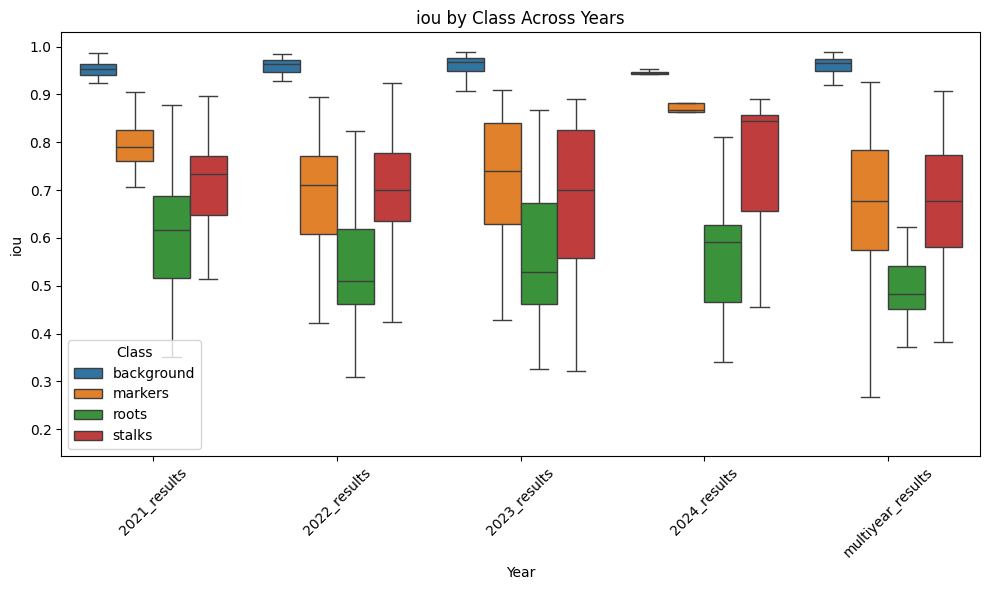

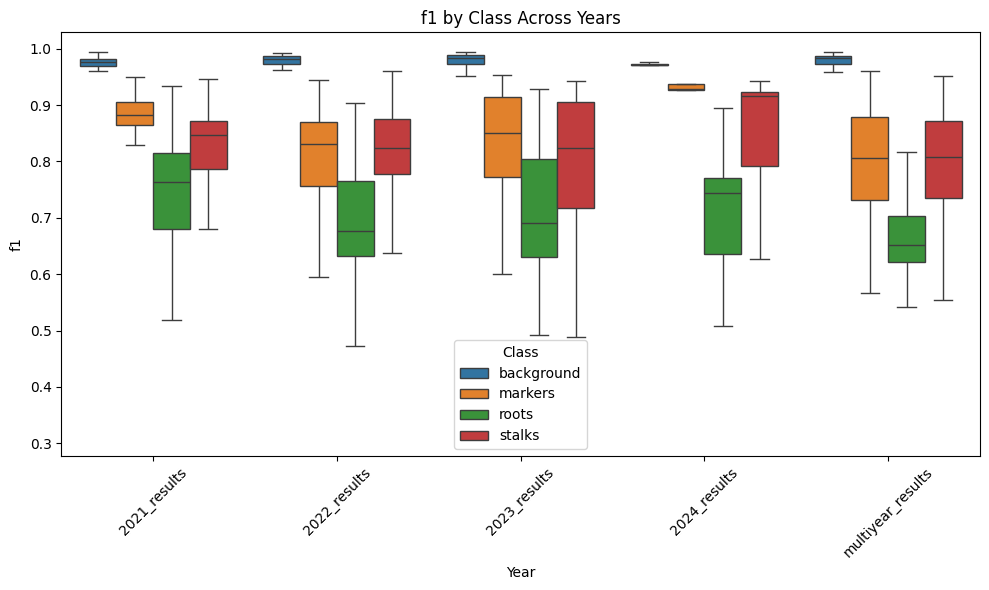

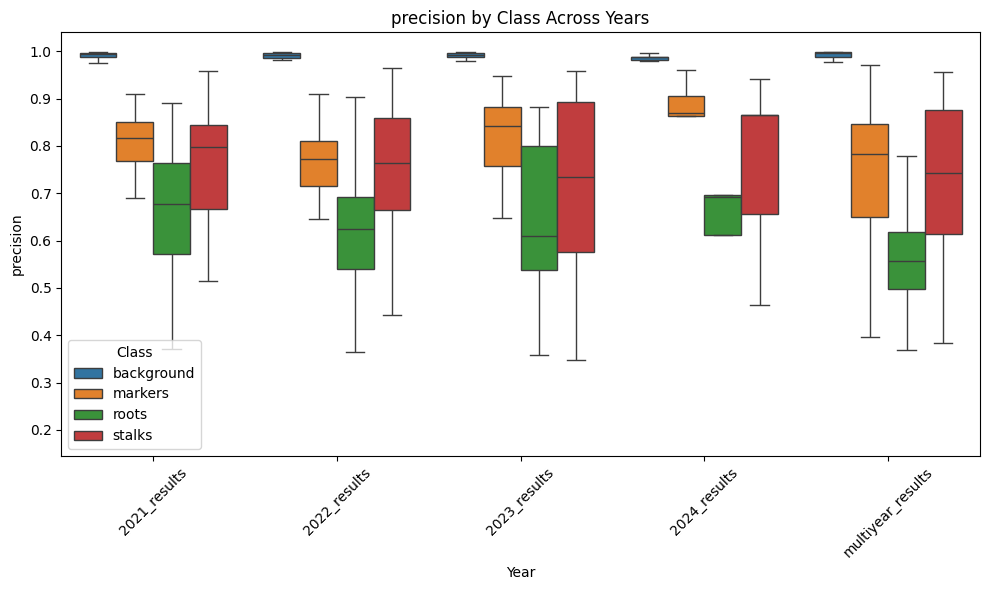

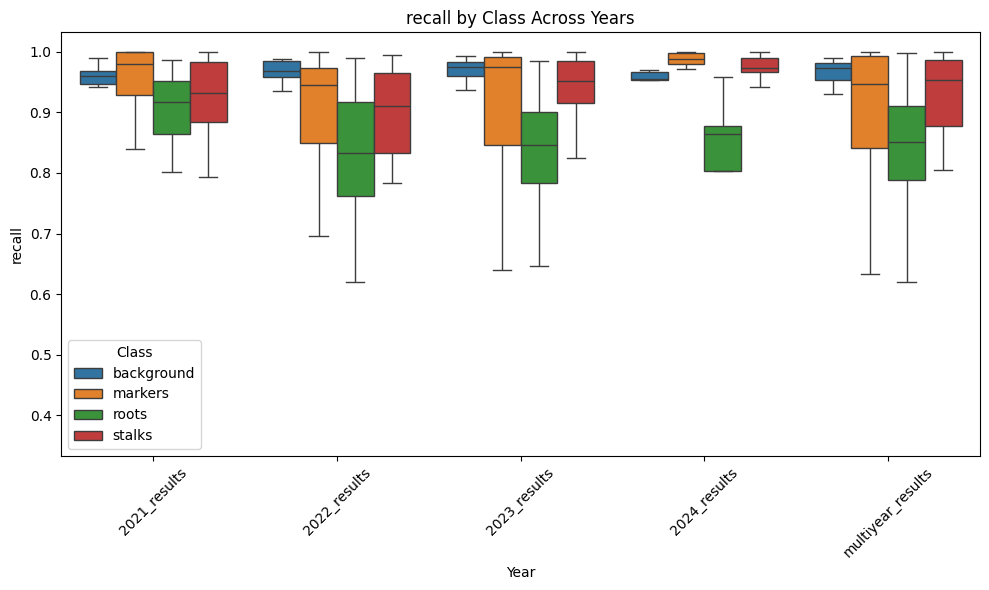

In [6]:
import seaborn as sns

print(data)
import matplotlib.pyplot as plt

for metric, years_dict in data.items():
    # assemble long‐form DataFrame for this metric
    records = []
    for year, classes_dict in years_dict.items():
        for cls_label, vals in classes_dict.items():
            for v in vals:
                records.append({'year': year, 'class': cls_label, 'value': v})
    df_plot = pd.DataFrame(records)
    label_map = {'0': 'background', '1': 'markers', '2': 'roots', '3': 'stalks'}
    
    df_plot['class'] = df_plot['class'].map(label_map)
    # draw boxplots: x=year, one box per class
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='year', y='value', hue='class', data=df_plot, fliersize=0)
    plt.title(f'{metric} by Class Across Years')
    plt.ylabel(metric)
    plt.xlabel('Year')
    plt.legend(title='Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Statistical Testing Plan: LOO vs. Multiyear Control

### 1. Define Hypotheses  
- H₀: The distribution of fold‐wise metric values for year Y equals that of the multiyear control.  
- H₁: The distributions differ.

### 2. Data Setup  
- Metrics: `iou`, `f1`, `precision`, `recall`  
- Classes: `background`, `markers`, `roots`, `stalks`  
- For each (metric, class), extract two samples of size N (fold count):  
    - Sample A = values for year Y  
    - Sample B = values for multiyear_results

### 3. Normality Assessment  
- Apply Shapiro–Wilk test to each sample.  
- If both p-values > 0.05 ⇒ assume normality; otherwise, treat as non-normal.

### 4. Choice of Statistical Test  
- **Normal data**: two-sample Welch’s t-test (unequal variances)  
- **Non-normal data**: Mann–Whitney U test  

### 5. Multiple Comparison Correction  
- Total comparisons = 4 metrics × 4 classes × 4 years = 64 tests  
- Control family-wise or false discovery rate via:  
    - Bonferroni correction (α / 64)  
    - Benjamini–Hochberg procedure  


### 6. Reporting  
- Tabulate for each (metric, class, year):  
    - Sample means ± std (or medians ± IQR)  
    - Test statistic and adjusted p-value  
    - Significance flag (e.g. *p* < 0.05)

In [ ]:
from scipy import stats
import numpy as np
import pandas as pd

# Define mapping for better readability
label_map = {'0': 'background', '1': 'markers', '2': 'roots', '3': 'stalks'}
year_list = ['2021_results', '2022_results', '2023_results', '2024_results']
metrics = ['iou', 'f1', 'precision', 'recall']
classes = ['0', '1', '2', '3']

# Create results dataframe
results = []

# Perform statistical tests
for metric in metrics:
    for cls in classes:
        for year in year_list:
            # Extract samples
            sample_year = data[metric][year][cls]
            sample_multi = data[metric]['multiyear_results'][cls]
            
            # Calculate basic statistics
            year_mean, year_std = np.mean(sample_year), np.std(sample_year)
            multi_mean, multi_std = np.mean(sample_multi), np.std(sample_multi)
            
            # Test for normality
            _, p_year = stats.shapiro(sample_year) if len(sample_year) >= 3 else (None, 0)
            _, p_multi = stats.shapiro(sample_multi) if len(sample_multi) >= 3 else (None, 0)
            
            # Choose appropriate test based on normality
            if p_year > 0.05 and p_multi > 0.05:
                # Normal data - use Welch's t-test
                stat, p_value = stats.ttest_ind(sample_year, sample_multi, equal_var=False)
                test_name = "Welch's t-test"
            else:
                # Non-normal data - use Mann-Whitney U test
                stat, p_value = stats.mannwhitneyu(sample_year, sample_multi)
                test_name = "Mann-Whitney U"
            
            # Store results
            results.append({
                'Metric': metric,
                'Class': label_map[cls],
                'Year': year.replace('_results', ''),
                'Year_Mean': year_mean,
                'Year_Std': year_std,
                'Multi_Mean': multi_mean,
                'Multi_Std': multi_std,
                'Test': test_name,
                'Statistic': stat,
                'p-value': p_value
            })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Apply Bonferroni correction
total_tests = len(results)
alpha = 0.05
results_df['Adjusted p-value'] = np.minimum(results_df['p-value'] * total_tests, 1.0)
results_df['Significant'] = results_df['Adjusted p-value'] < alpha

# Display the results
print(f"Total statistical tests performed: {total_tests}")
results_df

Total statistical tests performed: 64


,Metric,Class,Year,Year_Mean,Year_Std,Multi_Mean,Multi_Std,Test,Statistic,p-value,Adjusted p-value,Significant
0,iou,background,2021,0.949260,0.025644,0.958435,0.024524,Mann-Whitney U,331.0,0.079782,1.000000,False
1,iou,background,2022,0.957348,0.022937,0.958435,0.024524,Mann-Whitney U,419.0,0.652044,1.000000,False
2,iou,background,2023,0.960298,0.025294,0.958435,0.024524,Mann-Whitney U,486.0,0.599689,1.000000,False
3,iou,background,2024,0.921066,0.051480,0.958435,0.024524,Mann-Whitney U,28.0,0.024945,1.000000,False
4,iou,markers,2021,0.772301,0.101124,0.667909,0.148390,Mann-Whitney U,652.0,0.002891,0.185045,False
...,...,...,...,...,...,...,...,...,...,...,...,...
59,recall,roots,2024,0.832601,0.098977,0.830795,0.119504,Mann-Whitney U,77.0,0.945403,1.000000,False
60,recall,stalks,2021,0.921528,0.068519,0.923248,0.081811,Mann-Whitney U,415.0,0.610008,1.000000,False
61,recall,stalks,2022,0.897931,0.087392,0.923248,0.081811,Mann-Whitney U,343.0,0.115362,1.000000,False
62,recall,stalks,2023,0.927505,0.073243,0.923248,0.081811,Mann-Whitney U,447.0,0.970516,1.000000,False


In [8]:
# Additional storage for ANOVA results
anova_results = []

# For each metric and class, run ANOVA across all groups
for metric in metrics:
    for cls in classes:
        cls_name = label_map[cls]
        groups = []  # List of lists, one per group
        group_labels = []  # Parallel list of group labels

        for year in year_list + ['multiyear_results']:
            values = data[metric][year][cls]
            groups.append(values)
            group_labels.append(year.replace('_results', ''))

        # Run one-way ANOVA across these groups
        f_stat, p_val = stats.f_oneway(*groups)
        anova_results.append({
            'Metric': metric,
            'Class': label_map[cls],
            'F-statistic': f_stat,
            'p-value': p_val,
            'Significant': p_val < 0.05
        })
anova_df = pd.DataFrame(anova_results)
print(anova_df)

       Metric       Class  F-statistic   p-value  Significant
0         iou  background     2.827851  0.027727         True
1         iou     markers     4.241993  0.003018         True
2         iou       roots     2.158049  0.077832        False
3         iou      stalks     0.602692  0.661426        False
4          f1  background     2.878338  0.025630         True
5          f1     markers     3.492505  0.009798         True
6          f1       roots     1.816740  0.130001        False
7          f1      stalks     0.685820  0.603128        False
8   precision  background     0.951052  0.437147        False
9   precision     markers     2.241527  0.068540        False
10  precision       roots     2.200319  0.072984        False
11  precision      stalks     0.443765  0.776749        False
12     recall  background     2.466063  0.048571         True
13     recall     markers     1.854680  0.122873        False
14     recall       roots     0.834345  0.505916        False
15     r

In [10]:
# Compute variance and standard deviation for the multiyear model
multi_stats = []

for metric in metrics:
    for cls in classes:
        values = data[metric]['multiyear_results'][cls]
        var = np.var(values, ddof=1)   # sample variance
        std = np.std(values, ddof=1)   # sample standard deviation
        mean = np.mean(values)
        cov = std / mean if mean != 0 else np.nan  # coefficient of variation

        multi_stats.append({
            'Metric': metric,
            'Class': label_map[cls],
            'Mean': mean,
            'Std Dev': std,
            'Variance': var,
            'CoV': cov  # unitless measure of dispersion
        })

multi_stats_df = pd.DataFrame(multi_stats)
display(multi_stats_df)


,Metric,Class,Mean,Std Dev,Variance,CoV
0,iou,background,0.958435,0.024943,0.000622,0.026025
1,iou,markers,0.667909,0.150926,0.022779,0.225969
2,iou,roots,0.498275,0.113678,0.012923,0.228143
3,iou,stalks,0.665481,0.167378,0.028015,0.251514
4,f1,background,0.978612,0.013377,0.000179,0.013669
5,f1,markers,0.790710,0.117468,0.013799,0.148559
6,f1,roots,0.657606,0.103491,0.010710,0.157375
7,f1,stalks,0.785880,0.138155,0.019087,0.175796
8,precision,background,0.993044,0.006337,0.000040,0.006382
9,precision,markers,0.734667,0.160024,0.025608,0.217819
